In [2]:
from SnackTrackDataset import SnackTrackDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
import random
from SnackTrackBasicModel import BasicModel

In [2]:
# prepare dataset with participant split
# Load metadata (example dataframe)
metadata_file = "/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database/spectrograms/metadata.csv"  # Path to metadata file
metadata = pd.read_csv(metadata_file)

# Group by participant
participants = metadata['participant'].unique()

# Select one participant for validation
val_participant = random.choice(participants)  # Randomly select one participant
train_participants = [p for p in participants if p != val_participant]

# Create metadata subsets
train_metadata = metadata[metadata['participant'].isin(train_participants)]
val_metadata = metadata[metadata['participant'] == val_participant]

# Create datasets
train_dataset = SnackTrackDataset(train_metadata)
val_dataset = SnackTrackDataset(val_metadata)

train_size = len(train_dataset)
val_size = len(val_dataset)

print(f"Validation participant: {val_participant}")
print(f"Training participants: {train_participants}")

Validation participant: participant01
Training participants: ['participant02', 'participant05', 'participant04', 'participant03']


In [ ]:
# prepare dataset with random split
# Dataset and DataLoader
metadata_file = "/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database/metadata_balanced.csv"  # Path to metadata file
metadata = pd.read_csv(metadata_file)
dataset = SnackTrackDataset(metadata)

# Split into train and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [31]:
# Parameters
batch_size = 16
learning_rate = 0.001
num_epochs = 4

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize model, loss, optimizer
model = BasicModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

train_samples = []
train_predictions = []

for epoch in range(num_epochs):
    # perform training followed by validation
    for mode, loader, num_samples in [
        ("train", train_loader, train_size),
        ("val", val_loader, val_size)
    ]:
        # progress bar setup
        num_batches = int(ceil(num_samples / batch_size))
        pbar = tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train()
        else:
            model.eval()

        # initial values of the metrics (loss, accurracy)
        runningLoss = 0.
        correct_predictions = 0
        # total number of images that were processed
        total_samples = 0

        for spectrograms, labels in loader:

            #if mode == "train":
                # Randomize the labels
             #   labels = labels[torch.randperm(labels.size(0))]
            train_samples.extend(labels.numpy())

            # move tensors to the correct device
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            # forward step of model
            outputs = model(spectrograms)

            train_predictions.append(outputs.argmax(dim=1))
            #print(outputs.argmax(dim=1))

            # loss calculation
            loss = criterion(outputs, labels)

            # calculate metrix for progress bar
            num_batch_samples = len(spectrograms)
            runningLoss += loss.item()
            correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()
            total_samples += num_batch_samples

            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples,
                "accuracy": correct_predictions / total_samples
            })
            
            # if in train mode update weights
            if mode == "train":
                # backward step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
        epoch_loss = runningLoss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_accuracy)
        else:
            val_losses.append(epoch_loss)
            val_accuracy.append(epoch_accuracy)

        pbar.close()

Using device: mps


val epoch 3: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it, loss=0.0168, accuracy=0.903]


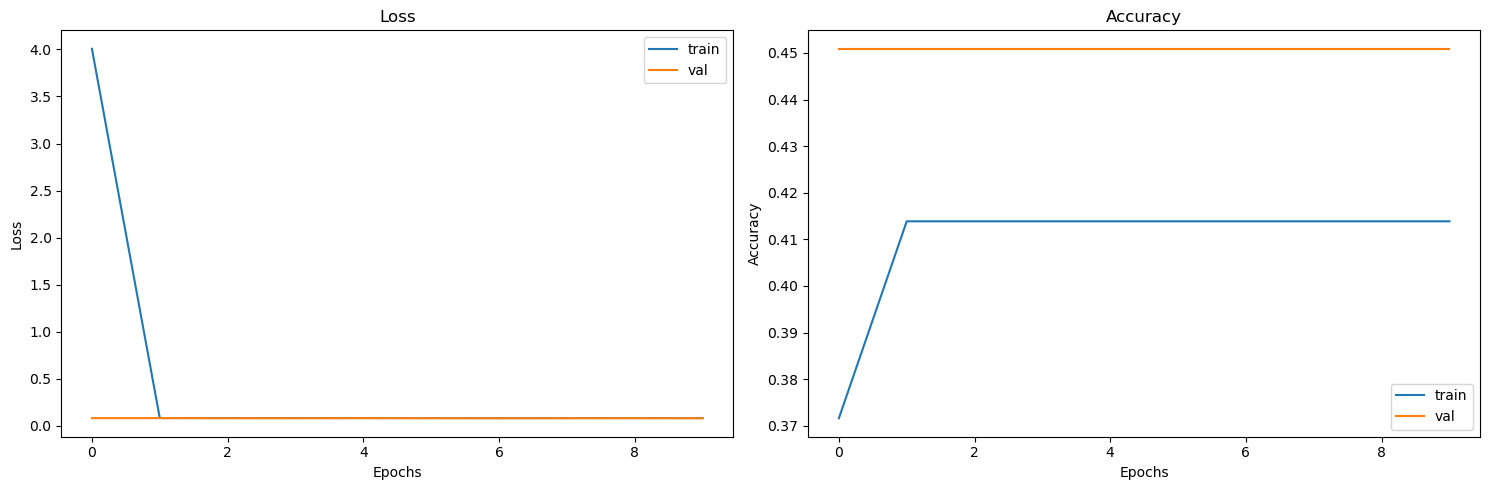

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].set_title("Loss")
axes[0].plot(train_losses, label="train")
axes[0].plot(val_losses, label="val")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot accuracy
axes[1].set_title("Accuracy")
axes[1].plot(train_accuracy, label="train")
axes[1].plot(val_accuracy, label="val")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

In [32]:
torch.save(model.state_dict(), 'STBasicModel.pth')